<a href="https://colab.research.google.com/github/heesukjang/W266_NLP_With_DeepLearning/blob/main/image_captioning_REFERENCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4: Image Captioning

This assignment is somewhat short.  We want you to spend your time on the project instead!

This assignment explores models connecting different modalities - exploring a connection between images and text.  By the time you're done with this assignment, you'll have:

* explored MS COCO captioning dataset
* investigated a few captioning techniques
* worked with CLIP embeddings for images and captions

### Setup

* run ```sudo apt install unzip``` to install the unzip executable that is required for this assignment.

### Data

* Download the 2014 validation images, as well as their annotations from https://cocodataset.org/#download.  On your GCP instance, a command like ```curl http://images.cocodataset.org/zips/val2014.zip --output val2014.zip``` for each will do what you need. You'll also want the file named `annotations_trainval2014.zip`.
* Unzip both files and name the corresponding directories `val2014` and `annotations` in this assignment directory.

**Note:** the file you are downloading is 6GB and takes a couple of minutes to unload.  Once you unzip the files, the ```val2014``` directory contains over 40,000 files.  Please do not list all of the files in your notebook because jupyter will be unhappy with a cell with over 40,000 lines of output.



In [ ]:
!sudo apt install unzip

In [133]:
!curl http://images.cocodataset.org/zips/val2014.zip --output val2014.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6337M  100 6337M    0     0  33.0M      0  0:03:11  0:03:11 --:--:-- 33.8M


In [134]:
!curl http://images.cocodataset.org/annotations/annotations_trainval2014.zip --output annotations_trainval2014.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  29.7M      0  0:00:08  0:00:08 --:--:-- 33.7M


In [135]:
!rm -rf val2014 annotations    # remove directories and their contents (rm) recursively (r) and forcibly without confirmation needed (f)
!mkdir val2014 annotations

In [136]:
# suppress displaying the output in the cell console using '> /dev/null' and you can access the unzipped files in the val2014 folder
# %%capture
!unzip val2014.zip > /dev/null

In [137]:
!unzip annotations_trainval2014.zip > /dev/null

### Explore the dataset
Look in the ```annotations``` directory.  Which file(s) contain the image captions?  Load those into memory here.  Your end goal is to generate a list of tuples for each of train2014 (you don't need the actual images to do this!) and val2014 i.e. ```[(391895, 'val2014/COCO_val2014_000000391895.jpg', 'A man with a red helmet on a small moped on a dirt road. '), ...]```

In [138]:
!ls -ltr /content/annotations   # -ltr: reverse output order, which is particularly useful when sorting by date

total 825032
-rw-rw-r-- 1 root root 332556225 Sep  1  2017 instances_train2014.json
-rw-rw-r-- 1 root root 160682675 Sep  1  2017 instances_val2014.json
-rw-r--r-- 1 root root 170733465 Sep  1  2017 person_keypoints_train2014.json
-rw-r--r-- 1 root root  81637509 Sep  1  2017 person_keypoints_val2014.json
-rw-rw-r-- 1 root root  66782097 Sep  1  2017 captions_train2014.json
-rw-rw-r-- 1 root root  32421077 Sep  1  2017 captions_val2014.json


In [139]:
!ls -c -ltd -- /content/annotations/*caption*.json   # find (list) JSON files containing "caption" in the file names

-rw-rw-r-- 1 root root 32421077 Mar 18 22:53 /content/annotations/captions_val2014.json
-rw-rw-r-- 1 root root 66782097 Mar 18 22:53 /content/annotations/captions_train2014.json


In [198]:
# import json

# # Open JSON files stored in my Google Drive
# with open('/content/annotations/captions_train2014.json') as json_train:
#   img_caption_train = json.load(json_train)

# print('Train Keys:')
# for key, val in img_caption_train.items():
#   pprint.pprint(key)

In [199]:
# # !pip install treelib
# # from treelib import Tree

# import pprint    # display the parsed data
# with open('/content/annotations/captions_val2014.json') as json_val:
#   img_caption_val = json.load(json_val)

# print('Val Keys:')
# for key, val in img_caption_val.items():
#   pprint.pprint(key)

In [166]:
### YOUR CODE HERE

import json

def create_list_of_tuples(data):
  data_list = []
  
  dict_image, dict_caption = {}, {}

  # Open JSON files stored in my Google Drive
  with open('/content/annotations/captions_' + data + '2014.json') as json_file:
    img_caption = json.load(json_file)

  # # Extract images/id and images/coco_url create a dict with key=id and value=file name 
  for img in img_caption['images']:
    dict_image[img['id']] = '/'.join(img['coco_url'].split('/')[-2:])

  for caption in img_caption['annotations']:
    dict_caption[caption['image_id']] = caption['caption']

  return img_caption, [(key, dict_image[key], dict_caption[key]) for key in set(dict_image.keys()).intersection(dict_caption)]

json_train, train2014 = create_list_of_tuples('train')
json_val, val2014 = create_list_of_tuples('val')
print(f'len(train2014) = {len(train2014)}\nlen(val2014) = {len(val2014)}')

### END YOUR CODE

len(train2014) = 82783
len(val2014) = 40504


In [209]:
# # json_train, train2014 = create_list_of_tuples('train')
# import math
# import numpy as np

# print(len(json_train['annotations'])/len(json_train['images']))
# print(math.ceil(3.4))
# print(round(3.5, 0))
# print(np.round(3.5))
# print(int(3.5))

In [207]:
# Cell if you want to write code to answer the questions below.

### YOUR CODE HERE
print(f'Q1. Number of images in the training set with captions = {len(train2014)}')
print(f'Q2. Number of captions per image in the training set = {round(len(json_train["annotations"])/len(json_train["images"]),0)}')

train_captions = []
for caption in train2014:
  train_captions.extend([w for w in caption[2].split()])
print(f'Q3. Number of distinct words in the training set = {len(set(train_captions))}')

### END YOUR CODE    

Q1. Number of images in the training set with captions = 82783
Q2. Number of captions per image in the training set = 5.0
Q3. Number of distinct words in the training set = 21312


### Questions (Part A)

1. How many images do we have captions for in the training set? **82783**
2. How many captions do we have per image (rounded to nearest integer) in the training set? **5**
3. If you just split the training captions on whitespace and do nothing else, how many words are in the vocabulary? **21312**

Given your answer to 3, think about what you might need to do with that few examples and that large of a vocabulary?  (Use pretrained embeddings from a massive semi-supervised dataset, keeping only the top-k tokens, smarter tokenization, ...).  You don't need to write your answer anywhere, but given how often these problems arise in NLP, you should be feeling more confident at this point in the course how to handle these situations!

## Let's look at some of the examples!

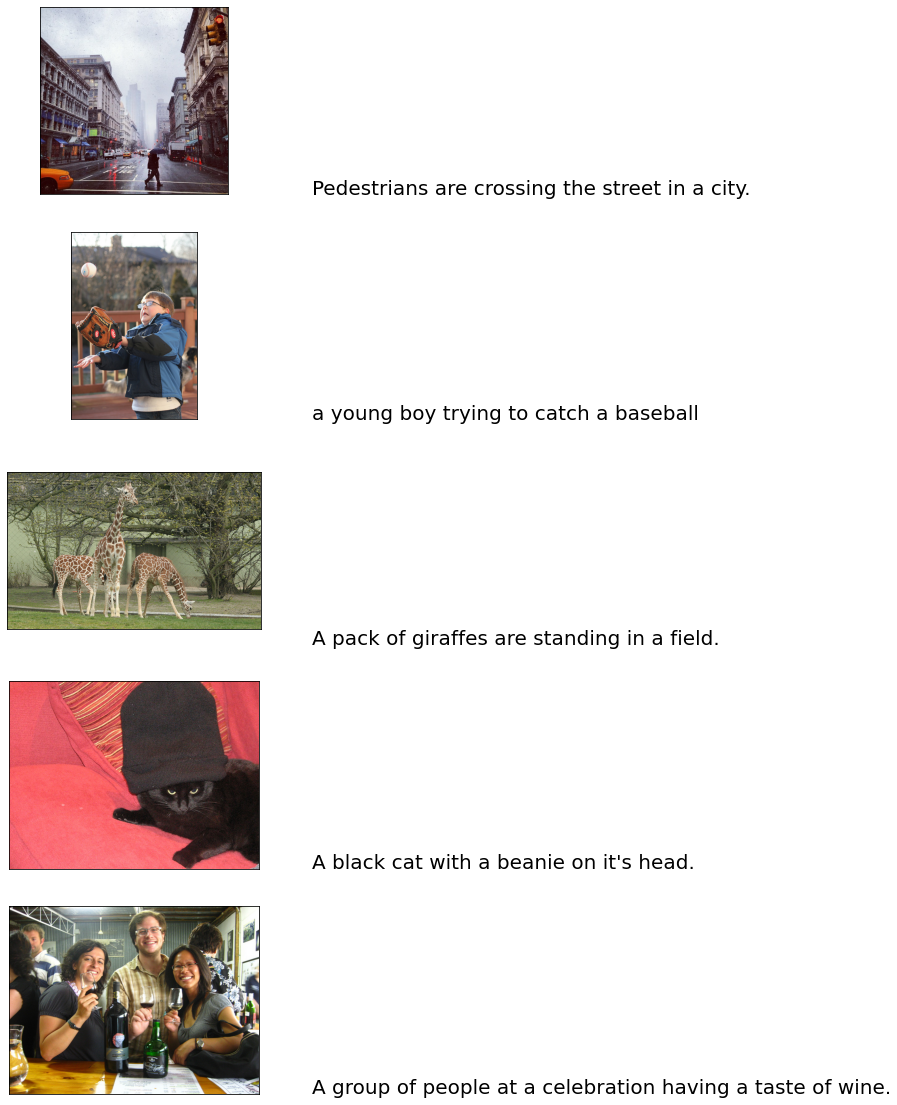

In [208]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import random

samples = 5
n = 1
fig = plt.figure(figsize=(10,20))
for i in range(samples):
    image_caption = val2014[random.randint(0, len(val2014))]
    image_load = load_img(image_caption[1])
    
    ax = fig.add_subplot(samples,2,n,xticks=[],yticks=[])
    ax.imshow(image_load)
    n += 1
    
    ax = fig.add_subplot(samples,2,n)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0, 0, image_caption[2], fontsize=20)
    n += 1
plt.show()

# Foundational image captioning papers

## Show & Tell

[Show and Tell: A Neural Image Caption Generator](https://arxiv.org/pdf/1411.4555.pdf) was the first step towards neural image captioning.  Fundamentally it is an encoder-decoder scheme similar to what we've seen in class.  Concretely, it uses the CNN structure of an (at the time) state of the art image classification CNN as the encoder and it uses an LSTM as a decoder.  As in the generation models in class, it continues to generate text until a special "stop" token is emitted.  After **reading** the paper, answer the following questions:

### Questions (Part B)

1.  What parts of the CNN were trained?
2.  What was the biggest concern when deciding how to train the model?
3.  How was the encoded image representation input into the decoder?
4.  Given we are "translating" from an image to a caption (without a length constraint), which evaluation metric did the authors determine was reasonable for a top line metric?
5.  What beam width is equivalent to one where you select the highest probability word in each decoding step?


## Deep Visual Alignment

[Deep Visual-Semantic Alignments for Generating Image Descriptions](https://cs.stanford.edu/people/karpathy/cvpr2015.pdf) is a fun read for which we will ask no questions.  Its critical insights are around understanding an image as a composition of regions, and building upon that understanding to construct both a caption for the whole image, but labels for its consistuent parts.

## Show, Attend & Tell

[Show, Attend & Tell](https://arxiv.org/pdf/1502.03044.pdf) applies the same "provide the decoder more context, as directly as possible" trick we've seen over the course: adding attention.  After **skimming** the paper, answer the following questions:

### Questions (Part C)

1. What is the attention over?
2. What do the figures with highlight shading represent in Figures 2, 3 and 5?

# Exploring a MS COCO captioner

There are many examples of image captioners ML engineers have built on the MS COCO dataset you explored. [This one](https://replicate.com/rmokady/clip_prefix_caption) uses a (more) modern large language model as its decoder, GPT-2.  

* **Explore** the samples and play with using beam search and not.  What do you notice?

This is an example from the Show & Tell paper of a low-quality caption (see figure 5).  The GPT-2 model proposes "the car that person drove to the hospital." vs. "A yellow school bus parked in a parking lot" from the original paper. ![Misclassified](littlecar.png) 

# CLIP Embeddings and Image Classification

The [CLIP paper](https://arxiv.org/pdf/2103.00020.pdf)  describes a system that emits encodings that represent both images and text captions. The system learns to match a picture with its caption so the encoding for the image and the encoding for an associated caption should have a very high cosine similarity.  Systems like DALL-E use CLIP embeddings to generate images based on a text description by using the text encoding to get the image encoding and then processing the image encoding to generate the final image.  We're going to use CLIP in the opposite direction.  Namely we're going to use CLIP embeddings to classify images, that is to score a set of captions for an image based on the image's content.

We can use the HuggingFace implementation of CLIP to experiment with this multimodal capability. 

In [ ]:
!pip install -q transformers

In [ ]:
import tensorflow as tf
from PIL import Image
import requests
from transformers import CLIPProcessor, TFCLIPModel

In [ ]:
model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Now let's begin our experiment.  We're going select two images that contain both zebras and cars.  They may contain other things as well.  We're also going to generate a set of captions that we will score.  Specifically, we'll pass the output for the captions through a softmax to give us a probability distribution over the four captions.

In [ ]:
# Example tags: animal = zebra, transport = car

urls = ["https://farm1.staticflickr.com/9/15631288_605abb3096_z.jpg", #zebras foreground, cars background
        "https://farm4.staticflickr.com/3057/3033996041_11293469b7_z.jpg"]  #zebra foreground, tiny car background
captions = ["a photo of cars",
            "a photo of a giraffe",
            "a photo of zebras in a field",
            "a photo of some zebras and cars"]

for url in urls:
    image = Image.open(requests.get(url, stream=True).raw)

    inputs = processor(
        text=captions, images=image, return_tensors="tf", padding=True
    )

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = tf.nn.softmax(logits_per_image, axis=1)  # we can take the softmax to get the label probabilities
    
    print()
    print(url)
    for i, caption in enumerate(captions):
        print('%40s - %.4f' % (caption, probs[0, i]))

The CLIP embeddings allow us to associate captions with images.  Specifically, we can build a classifier that assigns probabilities to each of the captions.  We want the highest probability to go to the most descriptive caption out of the four captions for the given image.  Notice here that even though both images contain zebras, one of them features a line of clearly visible cars.  The other image only has one small car off in the distance.  Note that the first image with the cars scores high for the caption of ```a photo of some zebras and cars``` because the zebras and cars are very visible.  The second image scores highest for ```a photo of zebras in a field``` but the small car is less noticed but scores above a zero.

In [ ]:
# Example tags: two dogs in bike, human bike tiny dog

urls = ["http://farm1.staticflickr.com/8/10896131_6a184b48cb_z.jpg",  #2 dogs in bike basket
        "http://farm4.staticflickr.com/3082/2797293301_dd26fd613f_z.jpg"] #human and bike with tiny dog
captions = ["a photo of a dog",
            "a photo of some dogs in a basket",
            "a photo of a bike",
            "a photo of some dogs with a bike"]

for url in urls:
    image = Image.open(requests.get(url, stream=True).raw)

    inputs = processor(
        text=captions, images=image, return_tensors="tf", padding=True
    )

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = tf.nn.softmax(logits_per_image, axis=1)  # we can take the softmax to get the label probabilities
    
    print()
    print(url)
    for i, caption in enumerate(captions):
        print('%40s - %.4f' % (caption, probs[0, i]))

Again, these two images both contain bicycles and dogs.  The first image is two dogs in a basket on the front of a bike.  While the bike is visible, the two dogs are the focus of the image.  The second image features a person with their bike.  The bike happens to contain a small dog.  We would expect the embeddings to reflect the different emphases of the photos and indeed they do.

In [ ]:
# Example tags: animal = dog, transport = bike

urls = ["http://farm1.staticflickr.com/124/405495389_d4316b1224_z.jpg",   #dog foreground and tiny bikes background
        "http://farm8.staticflickr.com/7194/6991675037_3c298541c0_z.jpg"] #motorbike foreground, many bikes and tiny dog background
captions = ["a photo of a dog",
            "a photo of a motorbike",
            "a photo of a plane",
            "a photo of some bikes"]

for url in urls:
    image = Image.open(requests.get(url, stream=True).raw)

    inputs = processor(
        text=captions, images=image, return_tensors="tf", padding=True
    )

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = tf.nn.softmax(logits_per_image, axis=1)  # we can take the softmax to get the label probabilities
    
    print()
    print(url)
    for i, caption in enumerate(captions):
        print('%40s - %.4f' % (caption, probs[0, i]))

For the third example, the first image includes a dog in the foreground and a number of small bikes in the distant background.  You can look at the annotations associated with the image to see where these objects are located. The second image includes a motorbike/motorcycle in the the foreground but a number of bikes and a tiny dog in the background.  Again we're hand crafting these captions to include the items in the image but we want the score for the caption to reflect what's in the foreground of the image.  

Now it is your turn.  You will essentially replicate the examples above but you will do it with images **you** select.  First you need to select *two* images for processing. Go to [the COCO Explorer](https://cocodataset.org/#explore), click on two tag icons: an animal (see icon column of animals) and a mode of transportation (see icon column of ), and search. (You pick which; you might have to try a few combinations until you get multiple image results.)

Find two different images that each contain your animal and your mode of transportation.  It's okay if they contain other things as well.  If you click on the URL icon above each image, you'll see a link to the annotated image and the original (unlabeled) image. Put the original image link in the code cell below *your image 1 url* and *your image 2 url*, then create four captions that mention only one of the objects each vs both objects together. You can see the captions we created for the three examples above.  The goal is to get probabilities above 0.85 for the caption that best describes the first image and the caption that best describes the second image.

As in the examples above, you must find a pair of images with the same two objects tagged in them, but which get different results for which caption has the highest probability according to the CLIP model.

Note which object tags you used, and give a brief explanation of what looks different about the two images that you think made them get different CLIP results for the most likely caption.  Enter that explanation in the cell below.  You **do not need to enter it in the answers sheet**.  Just leave it in the notebook that you submit. 

In [ ]:
# Example tags: animal = ???, transportation = ???

urls = ["your image 1 url",   #
        "your image 2 url"] #
captions = ["caption 1",
            "caption 2",
            "caption 3",
            "caption 4"]

for url in urls:
    image = Image.open(requests.get(url, stream=True).raw)

    inputs = processor(
        text=captions, images=image, return_tensors="tf", padding=True
    )

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = tf.nn.softmax(logits_per_image, axis=1)  # we can take the softmax to get the label probabilities
    
    print()
    print(url)
    for i, caption in enumerate(captions):
        print('%40s - %.4f' % (caption, probs[0, i]))

### Questions (Part D)

1. What is the animal tag you selected?

2. What is the transportation tag you selected?

3. What is the probability associated with the most likely caption for image 1?

4. What is the probability associated with the most likely caption for image 2?

**(Answer 5 below but do NOT enter your sentences in the answers file)**

5. Why do you think the differences between your two images are reflected in the 4 captions you produced.  

Please answer in two to four sentences right here: 

*YOUR Q 5 ANSWER HERE*

## Yay, you're done with your 266 homework.  Now focus on your project!